
# Convolution Neural Network - Application - TensorFlow

In [63]:
import math
import numpy as np
import scipy as sp
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

## 1. Load datasets

In [64]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Y= 4


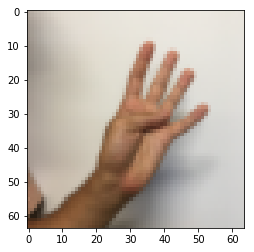

In [65]:
index = 5
plt.imshow(X_train_orig[index])
print("Y=",str(np.squeeze(Y_train_orig[:, index])))

In [66]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 2. Create placeholders

In [67]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X = tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32,shape=(None,n_y))
    
    return X,Y

In [68]:
create_placeholders(64, 64, 3, 6)

(<tf.Tensor 'Placeholder_2:0' shape=(?, 64, 64, 3) dtype=float32>,
 <tf.Tensor 'Placeholder_3:0' shape=(?, 6) dtype=float32>)

## 3. Initialize parameters

In [69]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {
        "W1":W1,
        "W2":W2
    }
    
    return parameters

In [70]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess.run(init)
    print("W1 = ", str(parameters["W1"].eval()[1,1,1]))
    print("W2 = ", str(parameters["W2"].eval()[1,1,1]))

W1 =  [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 =  [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## 4. Forward propagation

In [79]:
def forward_propagation(X,parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    P = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)
    
    return Z3

In [83]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation1(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[ 1.4416984  -0.24909666  5.450499   -0.2618962  -0.20669907  1.3654671 ]
 [ 1.4070846  -0.02573211  5.08928    -0.48669922 -0.40940708  1.2624859 ]]


## 5. Compute cost

In [84]:
def compute_cost(Z3,Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [85]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    sess.run(tf.global_variables_initializer())
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 4.6648693


## 6. Model

In [90]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m,n_H0,n_W0,n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X,Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X,parameters)
    
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _,temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost and epoch % 5 == 0:
                print("cost after epoch %i: %f" % (epoch,minibatch_cost))
            if print_cost and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

cost after epoch 0: 1.921332
cost after epoch 5: 1.904156
cost after epoch 10: 1.904309
cost after epoch 15: 1.904477
cost after epoch 20: 1.901876
cost after epoch 25: 1.784078
cost after epoch 30: 1.681051
cost after epoch 35: 1.618206
cost after epoch 40: 1.597971
cost after epoch 45: 1.566706
cost after epoch 50: 1.554487
cost after epoch 55: 1.502187
cost after epoch 60: 1.461036
cost after epoch 65: 1.304490
cost after epoch 70: 1.201760
cost after epoch 75: 1.163242
cost after epoch 80: 1.102885
cost after epoch 85: 1.087105
cost after epoch 90: 1.051911
cost after epoch 95: 1.018554


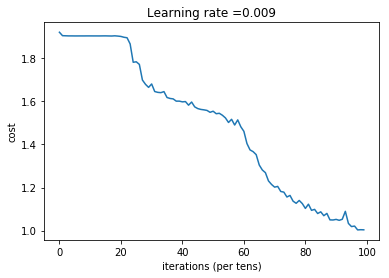

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6666667
Test Accuracy: 0.5833333


In [91]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)